In [1]:
# Import groundwater flow model utils
import sys

sys.path.insert(1, 'mlda/')


In [2]:
# Import packages
import os

#np.__config__.show()
os.environ['OPENBLAS_NUM_THREADS'] = '1'  # Set environmental variable
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1"

#import multiprocessing as mp
#mp.set_start_method('forkserver')

import time

from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import arviz as az

from Model import Model, model_wrapper, project_eigenpairs





WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# Set parameters

# Set the resolution of the multi-level models (from coarsest to finest)
# This is a list of different model resolutions. Each resolution added to the list will add one level to the multi-level inference. 
# Each element is a tuple (x,y) where x, y are the number of points in each dimension. For example, here we set resolutions = 
# [(30, 30), (120, 120)] which creates a coarse, cheap 30x30 model and a fine, expensive 120x120 model.
resolutions = [(30,30), (120,120)]

# Set random field parameters
field_mean = 0
field_stdev = 1
lamb_cov = 0.05

# Set number of unknown parameters (i.e. dimension of theta in posterior)
nparam = 3

# Number of draws from the distribution
ndraws = 5000

# Number of burn-in samples
nburn = 1000

# MLDA and Metropolis tuning parameters
tune = True
tune_interval = 100
discard_tuning = True

# number of independent chains to perfrom the MCMC algo
nchains = 4

# subsampling rate for MLDA
nsub = 5

# Do blocked/compounds sampling in Metropolis and MLDA 
# Note: This choice applies only to the coarsest level in MLDA 
# (where a Metropolis sampler is used), all other levels use block sampling
blocked = False

# Set the sigma for inference
sigma = 0.01

# data generation seed
data_seed = 12345

# sampling seed
sampling_seed = 12345

# datapoint list, will be both the x and y coordinates of the points of the physical domain [0,1]x[0,1] to build the grid
points_list = [0.1, 0.3, 0.5, 0.7, 0.9]

In [4]:
# Define the likelihood of data 

# define log-likelihood of data (normal distribution) (pag. 20 paper)
def my_loglik(my_model, theta, datapoints, data, sigma):
    """
    This returns the log-likelihood of my_model given theta,
    datapoints, the observed data and sigma. It uses the
    model_wrapper function to do a model solve.
    """
    output = model_wrapper(my_model, theta, datapoints)  
    #solves the groundwater problem for theta params and returns the solution on the specified datapoints
    return - (0.5/(sigma**2))*np.sum((output - data)**2)


# log-likelihood class
class LogLike(tt.Op):
    """
    Theano Op that wraps the log-likelihood computation, necessary to
    pass "black-box" fenics code into pymc3.
    """
    # Specify what type of object will be passed and returned to the Op when it is called. 
    # In our case we will be passing it a vector of values (the parameters that define our model and a model object) 
    # and returning a single "scalar" value (the log-likelihood).
    itypes = [tt.dvector]  # input expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs is a single scalar value (the log likelihood)

    def __init__(self, my_model, loglike, data, x, sigma):
        """
        Initialise the Op with various things that our log-likelihood function requires. 
        Below are the things that are needed in this particular example.

        Parameters
        ----------
        my_model:
            A Model object (defined in model.py) that contains the parameters
            and functions of out model.
        loglike:
            The log-likelihood function we've defined, in this example it is
            my_loglik.
        data:
            The "observed" data that our log-likelihood function takes in. These
            are the true data generated by the finest model in this example.
        x:
            The dependent variable (aka 'x') that our model requires. This is
            the datapoints in this example.
        sigma:
            The noise standard deviation that our function requires.
        """

        # add inputs as class attributes
        self.my_model = my_model
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma


        # method to actually evaluate 
    def perform(self, node, inputs, outputs):
        theta = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(self.my_model, theta, self.x, self.data, self.sigma)

        outputs[0][0] = np.array(logl) # output the log-likelihood


In [5]:
# Instantiate model object

# Note this can take several minutes for large resolutions (4 min 40 sec)
# Build the models from the parameters and the set resolutions
my_models = []
for r in resolutions:
    my_models.append(Model(r, field_mean, field_stdev, nparam, lamb_cov))

# Project eigenvectors from fine model (my_models[-1] is the last in the list, so the finest) to all coarse models
for i in range(len(my_models[:-1])):
    project_eigenpairs(my_models[-1], my_models[i])

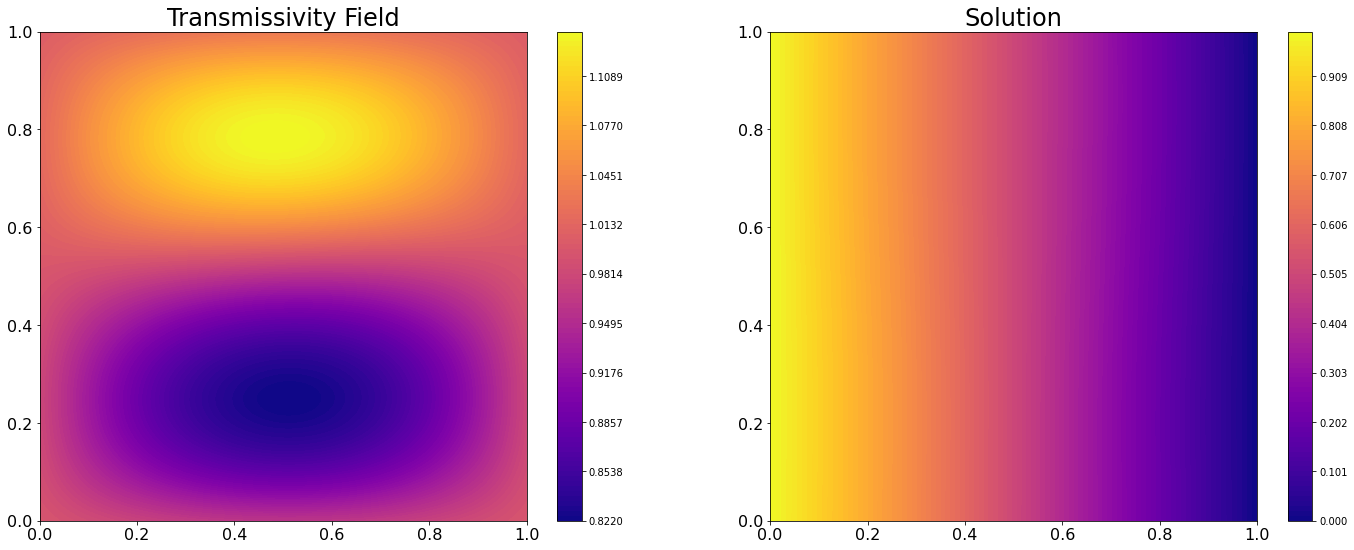

In [6]:
# Solve finest model as a test and plot transmissivity field and solution
np.random.seed(data_seed)
my_models[-1].solve()
my_models[-1].plot(lognormal=False)

# Save true parameters of finest model
true_parameters = my_models[-1].random_process.parameters

In [7]:
# Define the sampling points.
x_data = y_data = np.array(points_list)
datapoints = np.array(list(product(x_data, y_data)))    #gridpoints in the physical domain where to compute the solution with the fem solver

# Get data from the sampling points and perturb it with some noise
noise = np.random.normal(0, 0.001, len(datapoints))

# Generate data that are the solution of the problem on the grid 'datapoints' from the finest model for use in pymc3 inference - these data are used in all levels
data = model_wrapper(my_models[-1], true_parameters, datapoints) + noise

In [8]:
# Instanctiate LogLikelihood object of each model 

# create Theano Ops to wrap likelihoods of all model levels and store them in list
logl = []
for m in my_models:
    logl.append(LogLike(m, my_loglik, data, datapoints, sigma))

In [9]:
# Set up models in pymc3 for each level - excluding finest model level
coarse_models = []
for j in range(len(my_models) - 1):
    with pm.Model() as model:
        # uniform priors on parameters
        parameters = []
        for i in range(nparam):
            parameters.append(pm.Uniform('theta_' + str(i), lower=-3., upper=3.))

        # convert m and c to a tensor vector
        theta = tt.as_tensor_variable(parameters)

        # use a Potential function to construct the likelihood
        ll = logl[j]
        pm.Potential('likelihood', ll(theta))

    coarse_models.append(model)

In [10]:
# Perform inference

# Set up finest model and perform inference with PyMC3, using the MLDA algorithm
# and passing the coarse_models list created above.

method_names = []
traces = []
runtimes = []
acc = []
ess = []
ess_n = []
performances = []

# Starting samples taken from true parameter values
start = dict()
for i, p in enumerate(true_parameters):
    start['theta_' + str(i)] = p

with pm.Model():
    # Uniform priors on parameters
    parameters = []
    for i in range(nparam):
        parameters.append(pm.Uniform('theta_' + str(i), lower=-3., upper=3.))

    # Convert m and c to a tensor vector
    theta = tt.as_tensor_variable(parameters)

    # use a Potential for the likelihood
    pm.Potential('likelihood', logl[-1](theta))

    # Initialise an MLDA step method object, passing the subsampling rate and coarse models list
    # Also initialise the other step methods
    step_mlda = pm.MLDA(subsampling_rates=nsub, coarse_models=coarse_models,
                        tune=tune, base_tune_interval=tune_interval, base_blocked=blocked,
                        base_sampler='Metropolis')
        
    #MLDA
    t_start = time.time()
    method_names.append("MLDA")
    traces.append(pm.sample(draws=ndraws, step=step_mlda,
                            start=start,
                            chains=nchains, tune=nburn,
                            discard_tuned_samples=discard_tuning,
                            random_seed=sampling_seed,
                            cores=1,
                            progressbar=True))
    print('ha funzionato')
    runtimes.append(time.time() - t_start)
    


/home/carlo/.local/lib/python3.8/site-packages/pymc3/step_methods/mlda.py:386: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  warnings.warn(
/tmp/ipykernel_23459/3542360442.py:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample(draws=ndraws, step=step_mlda,
Sequential sampling (4 chains in 1 job)
MLDA: [theta_2, theta_1, theta_0]


The number of effective samples is smaller than 10% for some parameters.


ha funzionato


In [11]:
# run MLDA
print(true_parameters)
print(traces)
np.__config__.show()

[-0.20470766  0.47894334 -0.51943872]
[<MultiTrace: 4 chains, 5000 iterations, 6 variables>]
blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
    runtime_library_dirs = ['/usr/local/lib']
blas_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
    runtime_library_dirs = ['/usr/local/lib']
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
    runtime_library_dirs = ['/usr/local/lib']
lapack_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
    runtime_library_dirs = ['/usr/local/lib']
Support

In [14]:
# run Metropolis
with pm.Model():
    # Uniform priors on parameters
    parameters = []
    for i in range(nparam):
        parameters.append(pm.Uniform('theta_' + str(i), lower=-3., upper=3.))

    # Convert m and c to a tensor vector
    theta = tt.as_tensor_variable(parameters)

    # use a Potential for the likelihood
    pm.Potential('likelihood', logl[-1](theta))

    # Initialise an MLDA step method object, passing the subsampling rate and coarse models list
    # Also initialise the other step methods
    step_metropolis = pm.Metropolis(tune=tune, tune_interval=tune_interval, blocked=blocked)
    
    # Metropolis    
    t_start = time.time()
    method_names.append("Metropolis")
    traces.append(pm.sample(draws=ndraws, step=step_metropolis,
                            start=start,
                            chains=nchains, tune=nburn,
                            discard_tuned_samples=discard_tuning,
                            random_seed=sampling_seed,
                            cores=1))
    runtimes.append(time.time() - t_start)

/tmp/ipykernel_23459/375898314.py:21: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces.append(pm.sample(draws=ndraws, step=step_metropolis,


The estimated number of effective samples is smaller than 200 for some parameters.


In [15]:
# Plot comparison

for i, trace in enumerate(traces):
    acc.append(trace.get_sampler_stats('accepted').mean())
    ess.append(np.array(pm.ess(trace).to_array()))
    ess_n.append(ess[i] / len(trace) / trace.nchains)
    performances.append(ess[i] / runtimes[i])
    print(f'\nSampler {method_names[i]}: {len(trace)} drawn samples in each of '
          f'{trace.nchains} chains.'
          f'\nRuntime: {runtimes[i]} seconds'
          f'\nAcceptance rate: {acc[i]}'
          f'\nESS list: {ess[i]}'
          f'\nNormalised ESS list: {ess_n[i]}'
          f'\nESS/sec: {performances[i]}')

Got error No model on context stack. trying to find log_likelihood in translation.
/home/carlo/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.



Sampler MLDA: 5000 drawn samples in each of 4 chains.
Runtime: 3264.7077345848083 seconds
Acceptance rate: 0.97895
ESS list: [13454.15711091   982.05696432   985.90353371]
Normalised ESS list: [0.67270786 0.04910285 0.04929518]
ESS/sec: [4.12109083 0.30081007 0.3019883 ]

Sampler Metropolis: 5000 drawn samples in each of 4 chains.
Runtime: 5601.852912425995 seconds
Acceptance rate: 0.1477
ESS list: [3281.22806071  102.99007012  103.37260401]
Normalised ESS list: [0.1640614  0.0051495  0.00516863]
ESS/sec: [0.58573977 0.018385   0.01845329]


/home/carlo/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [16]:
# Performance speedup

print(f"\nMLDA vs. Metropolis performance speedup in all dimensions (performance measured by ES/sec):\n{np.array(performances[1]) / np.array(performances[0])}")


MLDA vs. Metropolis performance speedup in all dimensions (performance measured by ES/sec):
[0.14213222 0.0611183  0.06110597]


In [17]:
# Print true theta values and pymc3 sampling summary
print(f"\nDetailed summaries and plots:\nTrue parameters: {true_parameters}")
for i, trace in enumerate(traces):
    print(f"\nSampler {method_names[i]}:\n", pm.stats.summary(trace))

Got error No model on context stack. trying to find log_likelihood in translation.



Detailed summaries and plots:
True parameters: [-0.20470766  0.47894334 -0.51943872]


/home/carlo/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.



Sampler MLDA:
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta_0 -0.241  0.290  -0.791    0.291      0.002    0.002   13454.0   
theta_1  0.530  0.268   0.049    1.055      0.009    0.006     982.0   
theta_2 -0.584  0.273  -1.078   -0.053      0.009    0.006     986.0   

         ess_tail  r_hat  
theta_0   14498.0   1.00  
theta_1    2104.0   1.01  
theta_2    2079.0   1.00  


/home/carlo/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(



Sampler Metropolis:
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta_0 -0.227  0.292  -0.738    0.352      0.005    0.004    3281.0   
theta_1  0.521  0.256   0.089    1.001      0.026    0.020     103.0   
theta_2 -0.574  0.261  -1.083   -0.132      0.026    0.020     103.0   

         ess_tail  r_hat  
theta_0    3361.0   1.00  
theta_1     154.0   1.03  
theta_2     151.0   1.03  


Got error No model on context stack. trying to find log_likelihood in translation.
/home/carlo/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
/home/carlo/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in transla

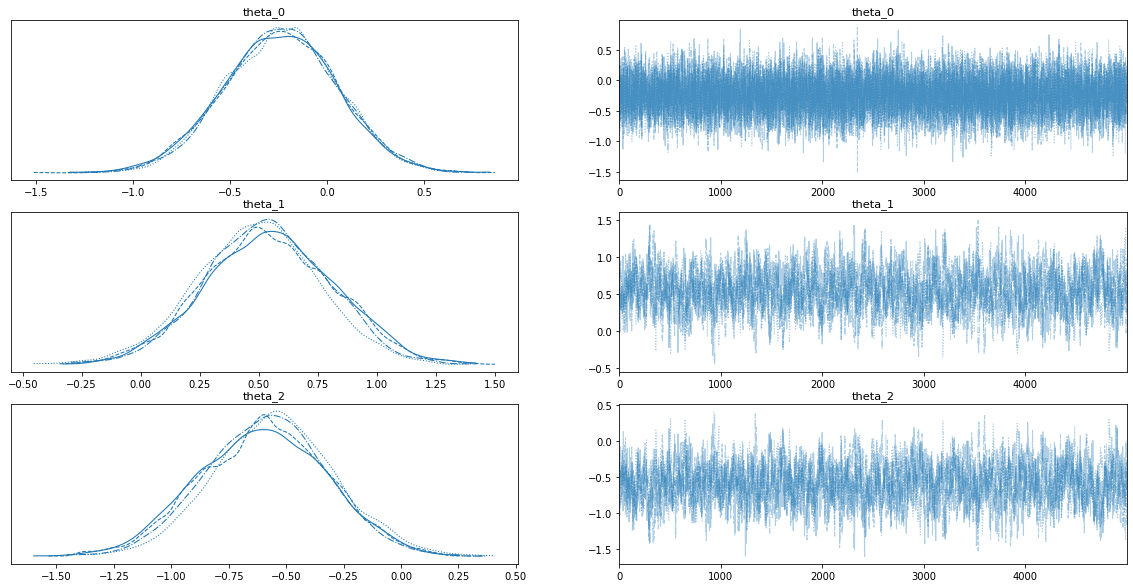

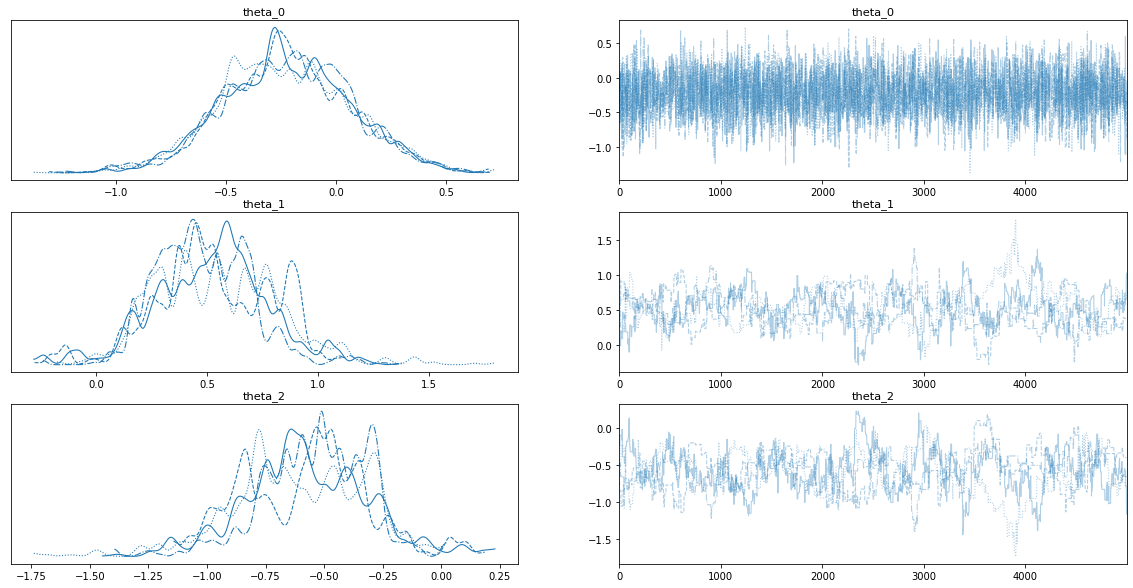

In [21]:
# Print true theta values and pymc3 sampling summary
# il primo è MLDA
# il secondo è Metropolis
for i, trace in enumerate(traces):
    az.plot_trace(trace, figsize=(20,10))

# vedo che è molto meglio MLDA

Got error No model on context stack. trying to find log_likelihood in translation.
/home/carlo/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/home/carlo/.local/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


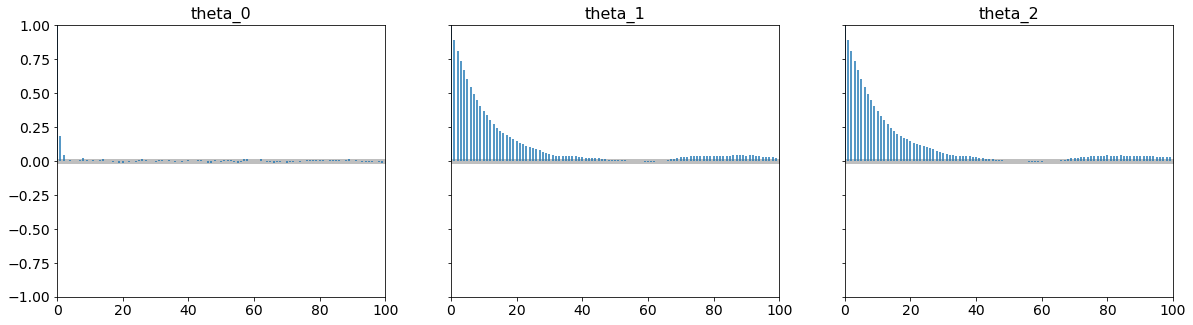

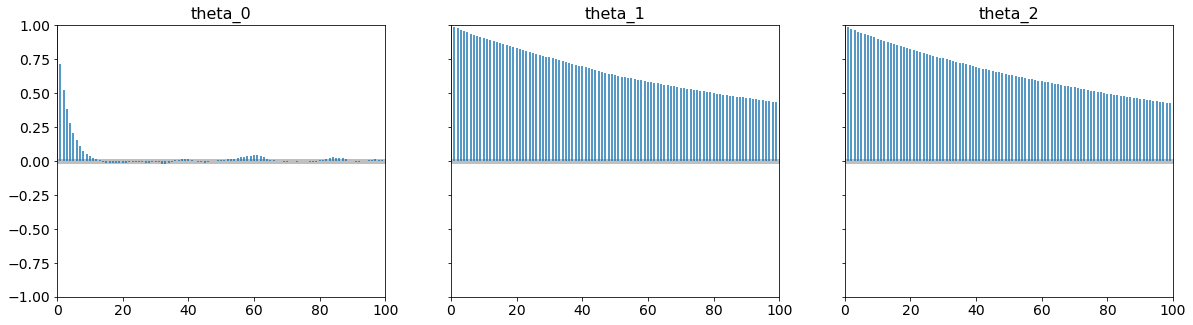

In [24]:
# Plot autocorrelation
# il primo è MLDA
# il secondo è Metropolis
for i, trace in enumerate(traces):
    az.plot_autocorr(trace, figsize=(20,5), combined=True)

# vedo che è molto meglio MLDA